In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

'2.8.0'

In [6]:
def ELA(img_path, quality=90):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff=""
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d=diff.load()
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

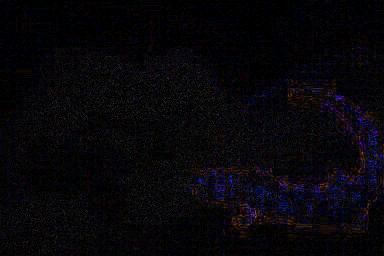

In [7]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im
Image.open('CASIA2/Tp/Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg')
convert_to_ela_image('CASIA2/Tp/Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg', 90)

In [4]:
dataset_path='C:/Users/Pallavi Pandey/CASIA_CNN/CASIA2'
path_original = '/Au/'
path_tampered = '/Tp/'
# path_mask='CASIA 2 Groundtruth/'
total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)
# total_mask=os.listdir(dataset_path+path_mask)

In [6]:

pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)


In [7]:
len(total_tampered),len(fake_images)

(5128, 5128)

In [8]:
image_size = (224,224)
output_path='./'

In [9]:
output_path='./'
if not os.path.exists(output_path+"resized_images/"):
#     os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 224
    width = 224
#     p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    j=0
    for fake_image in tqdm(total_tampered):
        try:
            if(j%3):
                j+=1
                continue
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
            j+=1
        except:
            print("Encountered Invalid File : ",fake_image)
        
    j=0
    for pristine_image in tqdm(total_original):
        try:
            if(j%3):
                j+=1
                continue
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
            j+=1
        except:
            print("Invalid File : " ,pristine_image)

In [10]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [11]:
len(resized_pristine_image)

2497

In [12]:
ela_images_path=output_path+'ELA_IMAGES/'
ela_real=ela_images_path+'Au/'
ela_fake=ela_images_path+'Tp/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    j=0
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)
        j+=1
        if(j==1500):
            break
    j=0
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)
        j+=1
        if(j==1500):
            break
else:
    print('Images are already converted to ELA')

Images are already converted to ELA


In [13]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==1500):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==1500):
        break

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|█████████▉| 1499/1500 [00:02<00:00, 707.52it/s]


In [14]:
X=np.array(X)
X.shape

(3000, 224, 224, 3)

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)

In [16]:
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Dropout,MaxPooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2

base_model=MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
x=Conv2D(1024,(3,3),padding='same',activation='relu')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dense(2,activation='softmax')(x)
model=Model(base_model.input,x)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [17]:
epochs = 10
batch_size = 20

In [18]:
import keras
# if not os.path.exists('./model_checkpoints'):
#     os.makedirs('./model_checkpoints')
# # define callbacks for learning rate scheduling and best checkpoints saving
# filepath = './model_checkpoints/image_tampering_classification_ela.h5'
# checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,verbose=1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13,verbose=1,restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [19]:
hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/10
75/75 [==============================] - 182s 2s/step - loss: 5.2225 - accuracy: 0.7583 - val_loss: 2.4682 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 166s 2s/step - loss: 1.8294 - accuracy: 0.7883 - val_loss: 1.4483 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 166s 2s/step - loss: 1.1071 - accuracy: 0.7933 - val_loss: 0.9811 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 186s 2s/step - loss: 0.7774 - accuracy: 0.7946 - val_loss: 0.7575 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 171s 2s/step - loss: 0.6099 - accuracy: 0.7946 - val_loss: 0.6327 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 170s 2s/step - loss: 0.5334 - accuracy: 0.7950 - val_loss: 0.5868 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - 167s 2s/step - loss: 0.4

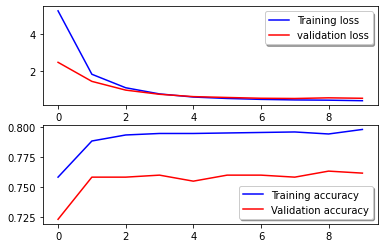

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [21]:
feature_extractor=base_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

#RANDOM FOREST
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
y_train_label=np.where(y_train==1)[1]

#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train_label) #For sklearn no one hot encoding

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
pip install xgboost

     -------------------------------------- 70.9/70.9 MB 844.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Accuracy =  0.795


<AxesSubplot:>

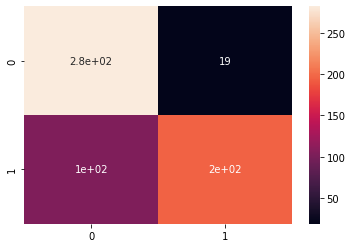

In [22]:
import seaborn as sns
X_test_feature = base_model.predict(x_dev)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
# prediction = le.inverse_transform(prediction)
y_test=np.where(y_dev==1)[1]
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
pred=model.predict(X_test_features)

In [25]:
# print("Loss of the model is - " , model.evaluate(X_test_features,y_test)[0])
# print("Accuracy of the model is - " , model.evaluate(X_test_features,y_test)[1]*100 , "%")
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       301
           1       0.91      0.65      0.76       299

    accuracy                           0.80       600
   macro avg       0.82      0.79      0.79       600
weighted avg       0.82      0.80      0.79       600

